In [2]:
%load_ext autoreload
%autoreload 2

import torch
from diffusers import ControlNetModel, DPMSolverMultistepScheduler
from text3d2video.pipelines.controlnet_pipeline import ControlNetPipeline
from text3d2video.ipython_utils import display_ims

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

dtype = torch.float16
device = torch.device("cuda")

controlnet = ControlNetModel.from_pretrained(
    controlnet_repo, torch_dtype=torch.float16
).to(device)

pipe = ControlNetPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
from text3d2video.artifacts.animation_artifact import AnimationArtifact
from text3d2video.rendering import render_depth_map

animation = AnimationArtifact.from_wandb_artifact_tag("backflip:latest")

mesh = animation.load_frame(1)
camera = animation.camera(1)

depth_map = render_depth_map(mesh, camera)[0]

100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


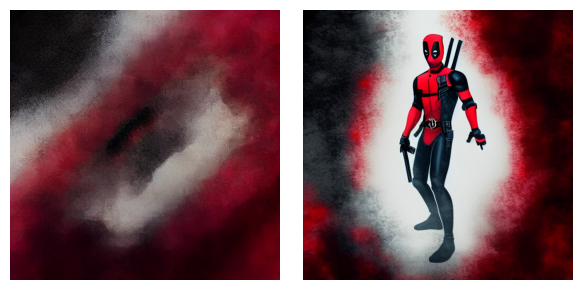

In [4]:
from text3d2video.identity_post_attn.identity_post_attn_render_processor import (
    IdentityPostAttnInjectionProcessor,
)

attn_processor = IdentityPostAttnInjectionProcessor()
attn_processor.mesh = mesh
attn_processor.camera = camera
pipe.unet.set_attn_processor(attn_processor)

with_post_attn = None
without_post_attn = None

for do_identity_post_attn in [True, False]:
    attn_processor.do_identity_post_attn = do_identity_post_attn
    images = pipe(
        ["Deadpool"],
        [depth_map],
        generator=torch.Generator(device=device),
        num_inference_steps=10,
    )

    if do_identity_post_attn:
        with_post_attn = images[0]
    else:
        without_post_attn = images[0]

display_ims([with_post_attn, without_post_attn], scale=3)

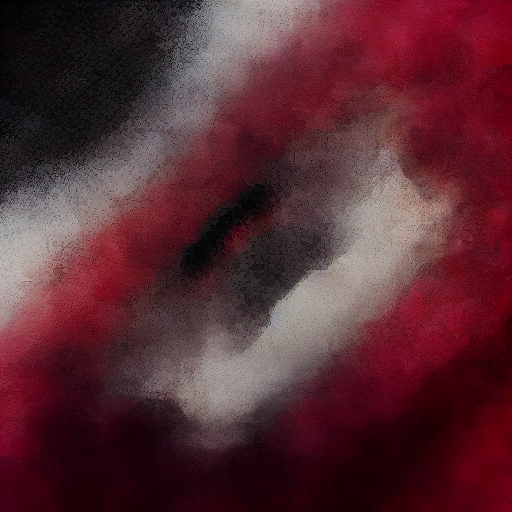

In [5]:
with_post_attn